# Supervised Classification for GRS1915+105 Light curves

In this notebook, we'll do some supervised classification on light curves of GRS 1915+105.
Let's get started!

First, we need some features. The details of feature extraction are explained in the accompanying notebook `GRS1915_Feature_Extraction.ipynb`. Here, we'll assume you've worked your way through that, and are ready to work with a feature vector you've made in there.

Therefore, we'll just load said feature vector:

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import sklearn
import cPickle as pickle
import feature_extraction
import generaltools as gt

datadir = "../../"

We'll load the features, labels and associated light curves and hardness ratios from the files we made in the feature extraction stage.

We need to use the features/light curves with the *longer* segment size (1024 seconds).

In [40]:
seg_length_supervised = 1024.

features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_supervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_supervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_supervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_supervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_supervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_supervised)[0])

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_supervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_supervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_supervised)

features_all_full = np.concatenate((features_train_full, features_val_full, features_test_full))

features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val= features_val_full[np.where(labels_val_full != "None")]

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]


In [41]:
lc_all_full = gt.getpickle(datadir+"grs1915_%is_lc_all.dat"%seg_length_supervised)
hr_all_full = gt.getpickle(datadir+"grs1915_%is_hr_all.dat"%seg_length_supervised)

lc_train_full = lc_all_full["train"]
lc_test_full = lc_all_full["test"]
lc_val_full = lc_all_full["val"]

hr_train_full = hr_all_full["train"]
hr_test_full = hr_all_full["test"]
hr_val_full = hr_all_full["val"]

In [42]:
features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val= features_val_full[np.where(labels_val_full != "None")]

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]


In [43]:
train_ind = np.where(labels_train_full != "None")[0]
lc_train = np.array([lc_train_full[i] for i in train_ind])
hr_train = np.array([hr_train_full[i] for i in train_ind])

val_ind = np.where(labels_val_full != "None")[0]
lc_val = np.array([lc_val_full[i] for i in val_ind])
hr_val = np.array([hr_val_full[i] for i in val_ind])

test_ind = np.where(labels_test_full != "None")[0]
lc_test = np.array([lc_test_full[i] for i in test_ind])
hr_test = np.array([hr_test_full[i] for i in test_ind])


To do the supervised learning, we will scale the data to a mean of zero and unit variance.

In [13]:
from sklearn import cross_validation 
from sklearn.preprocessing import StandardScaler

features_all = np.concatenate((features_train, features_val, features_test))

scaler_train = StandardScaler().fit(features_all_full)

fscaled_train = scaler_train.transform(features_train) 
fscaled_val = scaler_train.transform(features_val)
fscaled_test = scaler_train.transform(features_test)





Next, we're going to try the simplest algorithm we can: K-Nearest Neighbours.
We're going to cross-validate across some parameters (check documentation).

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV


#knn = KNeighborsClassifier(n_neighbors=5)
#knn.fit(features_train, labels_train) 
#print(knn.score(features_val, labels_val))

params = {'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]}#, 'max_features': }
grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, verbose=1, n_jobs=10)
grid.fit(fscaled_train, labels_train)


Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  42 out of  42 | elapsed:    0.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [16]:
print(grid.best_params_)
print(grid.score(fscaled_train, labels_train))
print(grid.score(fscaled_val, labels_val))


{'n_neighbors': 1}
1.0
0.788291354663


Plain nearest neighbour search gets us to $\sim78\%$. Let's try Random Forests, which is a bit more robust.

In [21]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [7, 10,12, 15,17, 18, 19, 20, 21, 22, 23, 25,30,40, 50, 100, 200, 500],
          'max_features':[2,3,4,5,6,7,8,10,20,25,30,31]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=1, n_jobs=10)
grid_rfc.fit(fscaled_train, labels_train)



Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  50 jobs       | elapsed:   20.7s
[Parallel(n_jobs=10)]: Done 200 jobs       | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 450 jobs       | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 648 out of 648 | elapsed:  5.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'max_features': [2, 3, 4, 5, 6, 7, 8, 10, 20, 25, 30, 31], 'max_depth': [7, 10, 12, 15, 17, 18, 19, 20, 21, 22, 23, 25, 30, 40, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [20]:
print(grid_rfc.best_params_)
print(grid_rfc.score(fscaled_train, labels_train))
print(grid_rfc.score(fscaled_val, labels_val))

labels_rfc = grid_rfc.predict(fscaled_val)


{'max_depth': 20}
1.0
0.808713410483


We can plot a confusion matrix to look at which classes tend to be confused:

[[ 57   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 107   0   0   0   0   0   0   0   0   0   6   0   0   0]
 [  0   0 185   0   0   4   0   0   0   0   0   0   0   0   0]
 [  1   0   0 238   0  26   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  13   0   0   0   0   0   0   0   0   0   0]
 [ 31   0   0  30  26  37   0   7   0   0   0  47   0   0   0]
 [  0   0   0   0   0   0  35   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 109   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  65   0   0   0   0   0   0]
 [  0  28   0   0   0   0   0   0   0  61  36   0   0   0   0]
 [  0  38   0   0   0   0   1   0   0   0  66   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  63   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  69   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  32]]


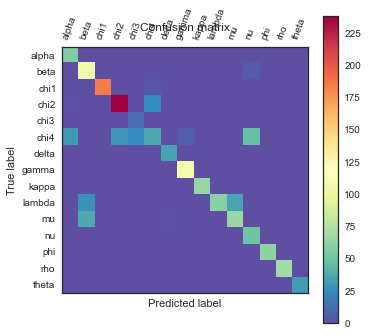

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap

sns.set_style("white") 
unique_labels = np.unique(labels_val)
cm = confusion_matrix(labels_val, labels_rfc, labels=unique_labels)
print(cm)
plt.matshow(cm, cmap=cmap.Spectral_r )
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)
plt.show()

There's still about $20\%$ confusion. However, the confusion is present in very specific classes:
* $\chi_4$ is often classified as $\alpha$
* $\lambda$ is often classified as $\beta$
* $\mu$ is often classified as $\beta$
* $\chi_4$ is often classified as $\chi_2$ and $\chi_3$ and $\nu$
* $\chi_2$ is often classified as $\chi_4$

There are two possible explanations for these classifications:
1. There is some information in the data that our features do not capture
2. The human classification isn't perfect

In practice, it's probably a combination of both.

In [18]:
labels_rfc_val = grid_rfc.predict(fscaled_val)


One useful diagnostic is to plot all the light curves that are confused and see whether we can see a consistent behaviour. 

In [33]:
misclassifieds = []
for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features_val, labels_rfc, labels_val, lc_val, \
                                            hr_val)):
    if lpredict == ltrue:
        continue
    else:
        misclassifieds.append([f, lpredict, ltrue, lc, hr])

In [49]:
import powerspectrum
nexamples = 6


for j,m in enumerate(misclassifieds):
    pos_human = np.random.choice([0,3], p=[0.5, 0.5])
    pos_robot = int(3. - pos_human)
    
    f = m[0]
    lpredict = m[1]
    ltrue = m[2]
    times = m[3][0]
    counts = m[3][1]
    hr1 = m[4][0]
    hr2 = m[4][1]
    print("Predicted class is: " + str(lpredict))
    print("Human classified class is: " + str(ltrue))
    robot_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                 zip(labels_val, labels_rfc, lc_val, hr_val)\
                 if lt == lpredict ]
    human_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                 zip(labels_val, labels_rfc, lc_val, hr_val)\
                 if lt == ltrue ]
    
    #print("robot_classes: " + str([r[0] for r in robot_all]))
    #print("human classes: " + str([h[0] for h in human_all]))
    np.random.shuffle(robot_all)
    np.random.shuffle(human_all)
    robot_all = robot_all[:6]
    human_all = human_all[:6]
    
    sns.set_style("darkgrid")
    current_palette = sns.color_palette()
    fig = plt.figure(figsize=(10,15))
    
    def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
        #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
        ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
        ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
        ax.set_xlim([times[0], times[-1]])
        ax.set_ylim([0.0, 12000.0])
        #print("plotting in grid point " + str((xcoords[1], ycoords[1])))
    
        ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
        ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
        ax.set_xlim([.27, 0.85])
        ax.set_ylim([0.04, 0.7])
    
        #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
        ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
        dt = np.min(np.diff(times))
        ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
        ax.loglog(ps.freq[1:], ps.ps[1:], linestyle="steps-mid", rasterized=True)
        ax.set_xlim([ps.freq[1], ps.freq[-1]])
        ax.set_ylim([1.e-6, 10.])
    
        return
    
    ## first plot misclassified:
    plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)
    
    ## now plot examples
    for i in range(4):
        r = robot_all[i]
        h = human_all[i]
        #print(h[0])
        #print("human indices: " + str([ [i+3, i+3, i+3], [pos_human, pos_human+1, pos_human+2]]))
        #print("robot indices: " + str([[i+3, i+3, i+3], [pos_robot, pos_robot+1, pos_robot+2]]))
        plot_lcs(h[2][0], h[2][1], h[3][0], h[3][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
        plot_lcs(r[2][0], r[2][1], r[3][0], r[3][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)
        
    ax = plt.subplot2grid((9,6),(8,pos_human+1))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
    ax = plt.subplot2grid((9,6),(8,pos_robot+1))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
    #plt.show()
    plt.savefig("misclassified%i.pdf"%j, format="pdf")
    plt.close()

Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: nu
Human classified class is: chi4
Predicted class is: nu
Human classified class is: chi4
Predicted class i

## Running Supervised Machine Learning on Various Feature Vectors

I'm going to try different combinations of feature vectors to see how well they do. 
I've already made various feature vectors that contain either (1) summary statistics of the light curve, PSD and HR diagram structure, (2) the full HR diagram (this would probably do better with a convolutional network, although I have few samples), (3) the full (logarithmically averaged) PSD.
All of those I have for different segment lengths (512s, 1024s, 2048s, full segments). 

In [2]:
import glob
files = glob.glob(datadir+"*features.dat")

files

['../grs1915_1024_hrfull_features.dat',
 '../grs1915_1024_hrfull_psfull_features.dat',
 '../grs1915_1024_psfull_features.dat',
 '../grs1915_1024_summary_features.dat',
 '../grs1915_2048_hrfull_features.dat',
 '../grs1915_2048_hrfull_psfull_features.dat',
 '../grs1915_2048_psfull_features.dat',
 '../grs1915_2048_summary_features.dat',
 '../grs1915_512_hrfull_features.dat',
 '../grs1915_512_hrfull_psfull_features.dat',
 '../grs1915_512_psfull_features.dat',
 '../grs1915_512_summary_features.dat',
 '../grs1915_noseg_hrfull_features.dat',
 '../grs1915_noseg_psfull_features.dat',
 '../grs1915_noseg_summary_features.dat']

In [2]:
f = '../grs1915_1024_hrfull_psfull_features.dat'
fin =  open(f, 'r')
features_all = pickle.load(fin)
fin.close()



In [3]:
features_train = np.array(features_all["train"][0]["features"])
features_val = np.array(features_all["val"][0][0]["features"])
features_test = np.array(features_all["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = features_all["train"][1]
labels_val = features_all["val"][0][1]
labels_test = features_all["test"][1]


features_train.shape: (633, 675)


In [4]:
import supervised_learning
grid, grid_rfc, grid_lm = supervised_learning.run_supervised(features_all)

features_train.shape: (633, 675)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   2 jobs       | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   5 jobs       | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   8 jobs       | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   9 out of  27 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  12 out of  27 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  15 out of  27 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  18 out of  27 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  21 out of  27 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  24 out of  27 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  27 out of  27 | elapsed:    0.7s finished


Best results for the K Nearest Neighbour run:
Best parameter: {'n_neighbors': 5}
Training accuracy: 0.865718799368[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=5 ...................................................
[CV] n_neighbors=5 ...................................................
[CV] n_neighbors=5 ...................................................
[CV] n_neighbors=10 ..................................................
[CV] .......................... n_neighbors=1, score=0.483721 -   0.0s
[CV] .......................... n_neighbors=1, score=0.589623 -   0.0s
[CV] .......................... n_

[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done   2 jobs       | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done   5 jobs       | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done   8 jobs       | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  13 jobs       | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  18 jobs       | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done  25 jobs       | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done  32 jobs       | elapsed:   19.7s
[Parallel(n_jobs=10)]: Done  36 out of  54 | elapsed:   20.4s remaining:   10.2s
[Parallel(n_jobs=10)]: Done  42 out of  54 | elapsed:   25.7s remaining:    7.3s
[Parallel(n_jobs=10)]: Done  48 out of  54 | elapsed:   26.3s remaining:    3.3s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:   28.4s finished


Best results for the Random Forest run:
Best parameter: {'max_depth': 40}
Training accuracy: 1.0[CV] max_depth=7 .....................................................
[CV] max_depth=7 .....................................................
[CV] max_depth=7 .....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=15 ....................................................
[CV] ............................ max_depth=7, score=0.776744 -   4.5s[CV] ............................ max_depth=7, score=0.853774 -   4.8s[CV] ............................ max_depth=7, score=0

[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   2 out of  18 | elapsed:    1.8s remaining:   14.2s
[Parallel(n_jobs=10)]: Done   4 out of  18 | elapsed:    2.0s remaining:    7.0s
[Parallel(n_jobs=10)]: Done   8 out of  18 | elapsed:    2.3s remaining:    2.9s
[Parallel(n_jobs=10)]: Done  10 out of  18 | elapsed:    2.4s remaining:    1.9s
[Parallel(n_jobs=10)]: Done   6 out of  18 | elapsed:    2.5s remaining:    5.0s
[Parallel(n_jobs=10)]: Done  12 out of  18 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=10)]: Done  14 out of  18 | elapsed:    3.8s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  16 out of  18 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed:    3.8s finished


Best results for the Linear Model run:
Best parameter: {'C': 0.01}
Training accuracy: 0.322274881517
Validation accuracy: 0.244979919679
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=1 .............................................................
[CV] ................................ C=0.001, score=0.200000 -   1.7s[CV] ................................ C=0.001, score=0.231132 -   1.7s[CV] ........

In [5]:
print("Best results for the K Nearest Neighbour run:")
print("Best parameter: " + str(grid.best_params_))
print("Training accuracy: " + str(grid.score(features_train, labels_train)))
print("Validation accuracy: " + str(grid.score(features_val, labels_val)))

print("Best results for the Random Forest run:")
print("Best parameter: " + str(grid_rfc.best_params_))
print("Training accuracy: " + str(grid_rfc.score(features_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(features_val, labels_val)))

print("Best results for the Linear Model run:")
print("Best parameter: " + str(grid_lm.best_params_))
print("Training accuracy: " + str(grid_lm.score(features_train, labels_train)))
print("Validation accuracy: " + str(grid_lm.score(features_val, labels_val)))



Best results for the K Nearest Neighbour run:
Best parameter: {'n_neighbors': 5}
Training accuracy: 0.865718799368
Validation accuracy: 0.44578313253
Best results for the Random Forest run:
Best parameter: {'max_depth': 40}
Training accuracy: 1.0
Validation accuracy: 0.815261044177
Best results for the Linear Model run:
Best parameter: {'C': 0.01}
Training accuracy: 0.322274881517
Validation accuracy: 0.244979919679


In [7]:
features_test.shape

(238, 281)

According to some tests, the 1024s segments with the full PSD work best, paired with the Random Forest Classifier. Let's run this again:

In [ ]:
f = '../grs1915_512_hrfull_features.dat'
fin =  open(f, 'r')
features_all = pickle.load(fin)
fin.close()

features_train = np.array(features_all["train"][0]["features"])
features_val = np.array(features_all["val"][0][0]["features"])
features_test = np.array(features_all["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = features_all["train"][1]
labels_val = features_all["val"][0][1]
labels_test = features_all["test"][1]


In [11]:
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV


from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.svm import LinearSVC

lc_train = features_all["train"][0]["lc"]
lc_val = features_all["val"][0][0]["lc"]
lc_test = features_all["test"][0]["lc"]

hr_train = features_all["train"][0]["hr"]
hr_val = features_all["val"][0][0]["hr"]
hr_test = features_all["test"][0]["hr"]

scaler_train = StandardScaler().fit(features_train)
fscaled_train = scaler_train.transform(features_train)

scaler_val = StandardScaler().fit(features_val)
fscaled_val = scaler_val.transform(features_val)

params = {'max_depth': [7, 10,12, 15,17, 18, 19, 20, 21, 22, 23, 25,30,40, 50, 100, 200, 500]}#,
         # 'max_features':[2,3,4,5,6,7,8,10,50,150,200,250,300]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=10, n_jobs=10)
grid_rfc.fit(features_train, labels_train)

print("Best results for the Random Forest run:")
print("Best parameter: " + str(grid_rfc.best_params_))
print("Training accuracy: " + str(grid_rfc.score(features_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(features_val, labels_val)))


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done   2 jobs       | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done   5 jobs       | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done   8 jobs       | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done  13 jobs       | elapsed:   22.0s
[Parallel(n_jobs=10)]: Done  18 jobs       | elapsed:   23.5s
[Parallel(n_jobs=10)]: Done  25 jobs       | elapsed:   34.7s
[Parallel(n_jobs=10)]: Done  32 jobs       | elapsed:   46.1s
[Parallel(n_jobs=10)]: Done  36 out of  54 | elapsed:   47.7s remaining:   23.9s
[Parallel(n_jobs=10)]: Done  42 out of  54 | elapsed:   58.6s remaining:   16.8s
[Parallel(n_jobs=10)]: Done  48 out of  54 | elapsed:  1.0min remaining:    7.5s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:  1.1min finished


Best results for the Random Forest run:
Best parameter: {'max_depth': 17}
Training accuracy: 1.0[CV] max_depth=7 .....................................................
[CV] max_depth=7 .....................................................
[CV] max_depth=7 .....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=15 ....................................................
[CV] ............................ max_depth=7, score=0.885714 -  10.3s[CV] ............................ max_depth=7, score=0.776493 -  10.5s[CV] ............................ max_depth=7, score=0

In [13]:
print("Test accuracy: " + str(grid_rfc.score(features_test, labels_test)))

Test accuracy: 0.858921161826


[[31  1  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  1  0  0  2  3]
 [ 0  0 84  0  0  1  0  0  0  0  0  0  0  0  0]
 [14  0  0 86  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  6  0 37  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0 27  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  2  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 40  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  4  0 29  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0 52]]
[[ 31   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0  39   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0  41   0   0   6   0   0   0   0   0   0   0   0   0]
 [  0   0   0 125   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  53   0  

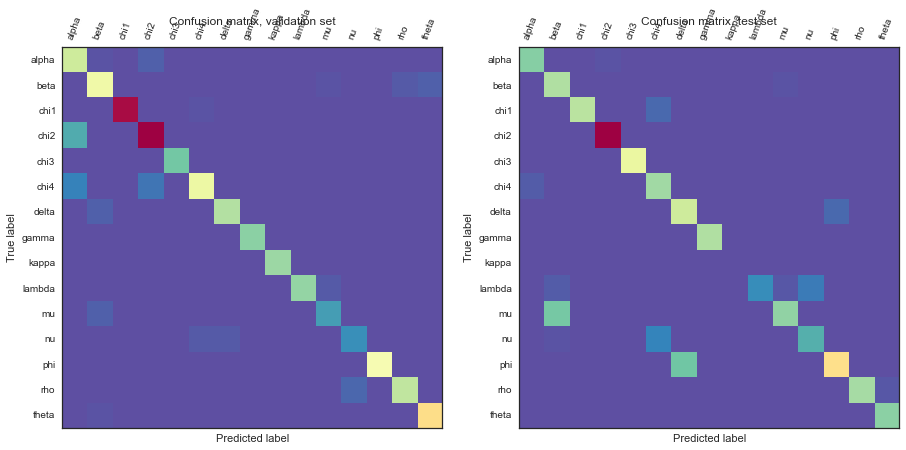

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap

fig = plt.figure(figsize=(15,8))
labels_rfc = grid_rfc.predict(features_val)
sns.set_style("white") 
unique_labels = np.unique(labels_val);
cm_val = confusion_matrix(labels_val, labels_rfc, labels=unique_labels);
#print(cm)
#print(unique_labels)
ax = fig.add_subplot(121)
ax.matshow(cm_val, cmap=cmap.Spectral_r );
ax.set_title('Confusion matrix, validation set')
#plt.colorbar()
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70);
plt.yticks(range(len(unique_labels)), unique_labels);
#plt.show()
#print(cm)

labels_rfc = grid_rfc.predict(features_test)
sns.set_style("white") 
unique_labels = np.unique(labels_val);
cm_test = confusion_matrix(labels_test, labels_rfc, labels=unique_labels);
#print(cm)
#print(unique_labels)
ax2=fig.add_subplot(122)
ax2.matshow(cm_test, cmap=cmap.Spectral_r);
ax2.set_title('Confusion matrix, test set')
#plt.colorbar()
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70);
plt.yticks(range(len(unique_labels)), unique_labels);
#plt.show()
#print(cm)
print(cm_val)
print(cm_test)

In general, the matrix is very sparse. This is good, because it means that on the whole, we classify pretty well. However, there is a significant difference in the classification errors between the validation and the test set. 
For the validation set, the largest source of uncertainty is in the classification of $\chi_2$ and $\chi_4$, which are routinely mis-classified as $\alpha$.

In the test set, these mis-classifications are rare; instead, there are prominent mis-classifications of $\mu$ (classified as $\beta$), $\nu$ (classified as $\chi_4$) and $\phi$ (misclassified as $\delta$) light curves. Also, light curves of class $\lambda$ are sometimes misclassified as class $\nu$). It is not clear (to me) where this deviation comes from or what to do about it, really.

For now, we'll plot the misclassified light curves in the validation and test sets with examples from both classes and compare the results.


In [ ]:
import powerspectrum

def plot_misclassifieds(features, trained_labels, real_labels, lc_all, hr_all,
                        nexamples=6, namestr="misclassified"):

    """
    Find all mis-classified light curves and plot them with examples of the real and false classes.
    """
    misclassifieds = []
    for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features, trained_labels, real_labels, lc_all, \
                                                hr_all)):
        if lpredict == ltrue:
            continue
        else:
            misclassifieds.append([f, lpredict, ltrue, lc, hr])

    for j,m in enumerate(misclassifieds):
        pos_human = np.random.choice([0,3], p=[0.5, 0.5])
        pos_robot = int(3. - pos_human)

        f = m[0]
        lpredict = m[1]
        ltrue = m[2]
        times = m[3][0]
        counts = m[3][1]
        hr1 = m[4][0]
        hr2 = m[4][1]
        print("Predicted class is: " + str(lpredict))
        print("Human classified class is: " + str(ltrue))
        robot_all = [[lp, lt, lc, hr] for lp, lt, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lt == lpredict ]
        human_all = [[lp, lt, lc, hr] for lp, lt, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lt == ltrue ]

        np.random.shuffle(robot_all)
        np.random.shuffle(human_all)
        robot_all = robot_all[:6]
        human_all = human_all[:6]

        sns.set_style("darkgrid")
        current_palette = sns.color_palette()
        fig = plt.figure(figsize=(10,15))

        def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
            #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
            ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
            ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
            ax.set_xlim([times[0], times[-1]])
            ax.set_ylim([0.0, 12000.0])
            #print("plotting in grid point " + str((xcoords[1], ycoords[1])))

            ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            ax.set_xlim([.27, 0.85])
            ax.set_ylim([0.04, 0.7])

            #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
            ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
            dt = np.min(np.diff(times))
            ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
            ax.loglog(ps.freq[1:], ps.ps[1:], linestyle="steps-mid", rasterized=True)
            ax.set_xlim([ps.freq[1], ps.freq[-1]])
            ax.set_ylim([1.e-6, 10.])

            return

        ## first plot misclassified:
        plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)

        ## now plot examples
        for i in range(4):
            r = robot_all[i]
            h = human_all[i]
            #print(h[0])
            #print("human indices: " + str([ [i+3, i+3, i+3], [pos_human, pos_human+1, pos_human+2]]))
            #print("robot indices: " + str([[i+3, i+3, i+3], [pos_robot, pos_robot+1, pos_robot+2]]))
            plot_lcs(h[2][0], h[2][1], h[3][0], h[3][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
            plot_lcs(r[2][0], r[2][1], r[3][0], r[3][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)

        ax = plt.subplot2grid((9,6),(8,pos_human+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
        ax = plt.subplot2grid((9,6),(8,pos_robot+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
        plt.savefig("misclassified%i.pdf"%j, format="pdf")
        plt.close()

## Classifying the entire data set

To compare with unsupervised methods, we're going to train on the entire supervised set, then use that to classify the unknown data points and plot a light curve.

In [19]:
fscaled_all = scaler_train.transform(features_all) 

labels_all = np.concatenate((labels_train, labels_val, labels_test))

from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [7, 10,12, 15, 20, 25,30,40, 50, 100, 200, 500]}#, 
         # 'max_features':[2,3,4,5,6,7,8,10,50,150,200,250,300]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params, 
                        verbose=10, n_jobs=10)
grid_rfc.fit(fscaled_all, labels_all)
print(grid_rfc.best_params_)
print(grid_rfc.score(fscaled_all, labels_all))
#print(grid_rfc.score(features_val, labels_val))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done   2 jobs       | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done   5 jobs       | elapsed:   15.5s
[Parallel(n_jobs=10)]: Done   8 jobs       | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done  13 jobs       | elapsed:   28.8s
[Parallel(n_jobs=10)]: Done  18 out of  36 | elapsed:   32.7s remaining:   32.7s
[Parallel(n_jobs=10)]: Done  22 out of  36 | elapsed:   44.8s remaining:   28.5s
[Parallel(n_jobs=10)]: Done  26 out of  36 | elapsed:   48.1s remaining:   18.5s
[Parallel(n_jobs=10)]: Done  30 out of  36 | elapsed:   48.8s remaining:    9.8s
[Parallel(n_jobs=10)]: Done  34 out of  36 | elapsed:   56.7s remaining:    3.3s
[Parallel(n_jobs=10)]: Done  36 out of  36 | elapsed:   57.1s finished


{'max_depth': 25}
1.0[CV] max_depth=7 .....................................................
[CV] max_depth=7 .....................................................
[CV] max_depth=7 .....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=12 ....................................................
[CV] max_depth=15 ....................................................
[CV] ............................ max_depth=7, score=0.813873 -  12.7s[CV] ............................ max_depth=7, score=0.841251 -  12.9s[CV] ............................ max_depth=7, score=0.840023 -  12.9s[CV] ........................... max_depth=10, score=0.8549

In [20]:
print(grid_rfc.best_params_)
rfc = RandomForestClassifier(n_estimators=500,max_depth=200)
rfc.fit(fscaled_all, labels_all)

{'max_depth': 25}


RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=200, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [21]:
rfc.score(fscaled_all, labels_all)

1.0

In [30]:
fscaled_all_full = scaler_train.transform(features_all_full)
labels_trained_full = rfc.predict(fscaled_all_full)

Test whether when predicting *everything*, it still predicts the training set correctly.

In [31]:
labels_all_full = np.concatenate((labels_train_full, labels_val_full, labels_test_full))
labels_trained = labels_trained_full[np.where(labels_all_full != "None")]
rfc.score(fscaled_all, labels_trained)

Let's look at the distribution of states:

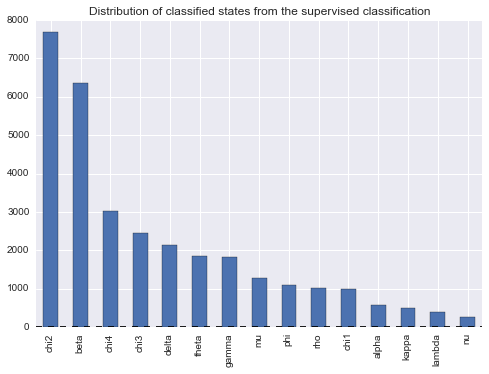

In [36]:

st = pd.Series(labels_trained_full)
nstates = st.value_counts()
nstates.plot(kind='bar')
plt.title("Distribution of classified states from the supervised classification")
#plt.savefig(datadir+"grs1915_kmeans_clusterid_cluster%i.pdf"%int(p), format="pdf")
#plt.close()


Let's look what the states look like over time.

In [40]:
colors = sns.color_palette("hls", 15)
pred_label_set = set(list(labels_trained_full))
print(pred_label_set)
tstart_all_full = np.concatenate((tstart_train_full, tstart_val_full, tstart_test_full))

set(['phi', 'kappa', 'alpha', 'chi2', 'chi3', 'chi1', 'chi4', 'mu', 'beta', 'rho', 'delta', 'theta', 'nu', 'gamma', 'lambda'])


In [47]:
asm = np.loadtxt(datadir+"grs1915_asm_lc.txt",skiprows=5)
asm_time = asm[:,0]
asm_cr = asm[:,1]
asm_total = asm_time[-1]-asm_time[0]
print("The ASM light curve covers a total of %i days"%asm_total)

mjdrefi = 49353. 
tstart_all_days = tstart_all_full/(60.*60.*24.)
tstart_all_mjd = tstart_all_days + mjdrefi

## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len
i = 0

fig = plt.figure(figsize=(12,15))

sns.set_style("white")

ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("darkgrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

current_palette = sns.color_palette()
while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    ax1 = fig.add_subplot(11,1,i+1)
    ax1.errorbar(asm[:,0], asm[:,1], yerr = asm[:,2], linestyle="steps-mid")
    for k, col in zip(range(len(pred_label_set)), colors):
        my_members = labels_trained_full[np.where(labels_trained_full == k)[0]]
        print(len(my_members))
        #cluster_center = cluster_centers[k]
        ax.plot(tstart_all_mjd, np.ones(len(tstart_all_mjd))*240.,".", color=col, label="state " + str(k))
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    plt.yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1

ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

#plt.savefig(paperdir+"grs1915_asm_lc_all.pdf", format="pdf")
#plt.close()

The ASM light curve covers a total of 5725 days
I am on plot 0.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 1.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 2.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 3.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 4.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 5.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 6.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 7.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 8.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 9.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
I am on plot 10.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [66]:
asdf = np.loadtxt("../"+"grs1915_256s_asdf_scaled.txt")
asdf.shape

(31424, 2)

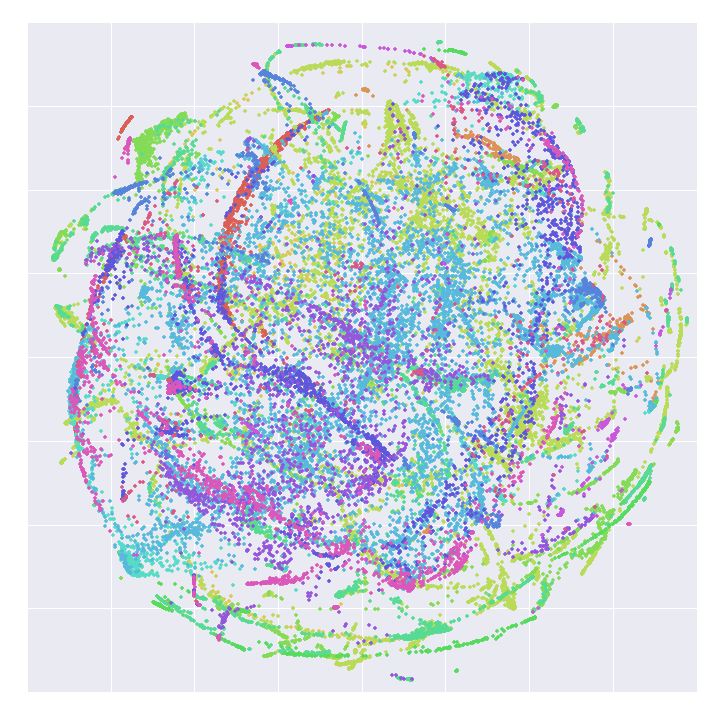

In [67]:
import matplotlib

#lall_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
#plt.scatter(asdf[:, 0], asdf[:, 1], c=ltrain_numeric)
 
colors = sns.color_palette("hls", 15)
#plt.scatter(asdf[:,0], asdf[:,1])
for k, col in zip(pred_label_set, colors):
    my_members = np.where(labels_trained_full == k)[0]
    #print(my_members)
    #cluster_center = cluster_centers[k]
    ax.plot(asdf[my_members, 0], asdf[my_members, 1],".", color=col, label="cluster " + str(k))
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    #         markeredgecolor='k', markersize=14)
#plt.show()
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('#ffffff')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')
ax.set_title("t-SNE plot for the entire GRS1915+105 data set, with K-Means clustered labels")


In [62]:
k

14